In [56]:
# Script for Bayesian parametric inference for Generalised Extreme Value Distribution (GEV)
# Dawar Qureshi (April, 2021)
# Metropolis-Hastings algorithm:
# adapted from Joseph Moukarzel (Towards data science: https://tinyurl.com/yxaqdjv2)

import matplotlib.pyplot as plt # package for good plots
import pandas as pd             # package for data analytics
import numpy as np              # package for efficient numerics
import plotly.offline as py     # for dynamic plots
import cufflinks as cf          # plotly bindings for pandas
import seaborn as sns           # for nice plots
import scipy.stats as stats     # fit a GEV distribution




In [57]:
Data1 = ('/Users/dawarqureshi/Dropbox/My Mac (Dawars-MacBook-Pro.local)/Desktop/AMS_Zürich/AMS_1h.txt')
data1 = pd.read_csv(filepath_or_buffer=Data1,header =0)
datin = pd.DataFrame({'data1':data1['AMS_1h']})

In [58]:
# use scipy.stats to get the 'best guess' values of parameters
shape1, loc1, scale1 =stats.genextreme.fit(datin.data1)
print(shape1, loc1, scale1)

-0.07499057642487139 14.728076996350378 5.386821894629199


<AxesSubplot:title={'center':'Maximum annual prcipitation'}>

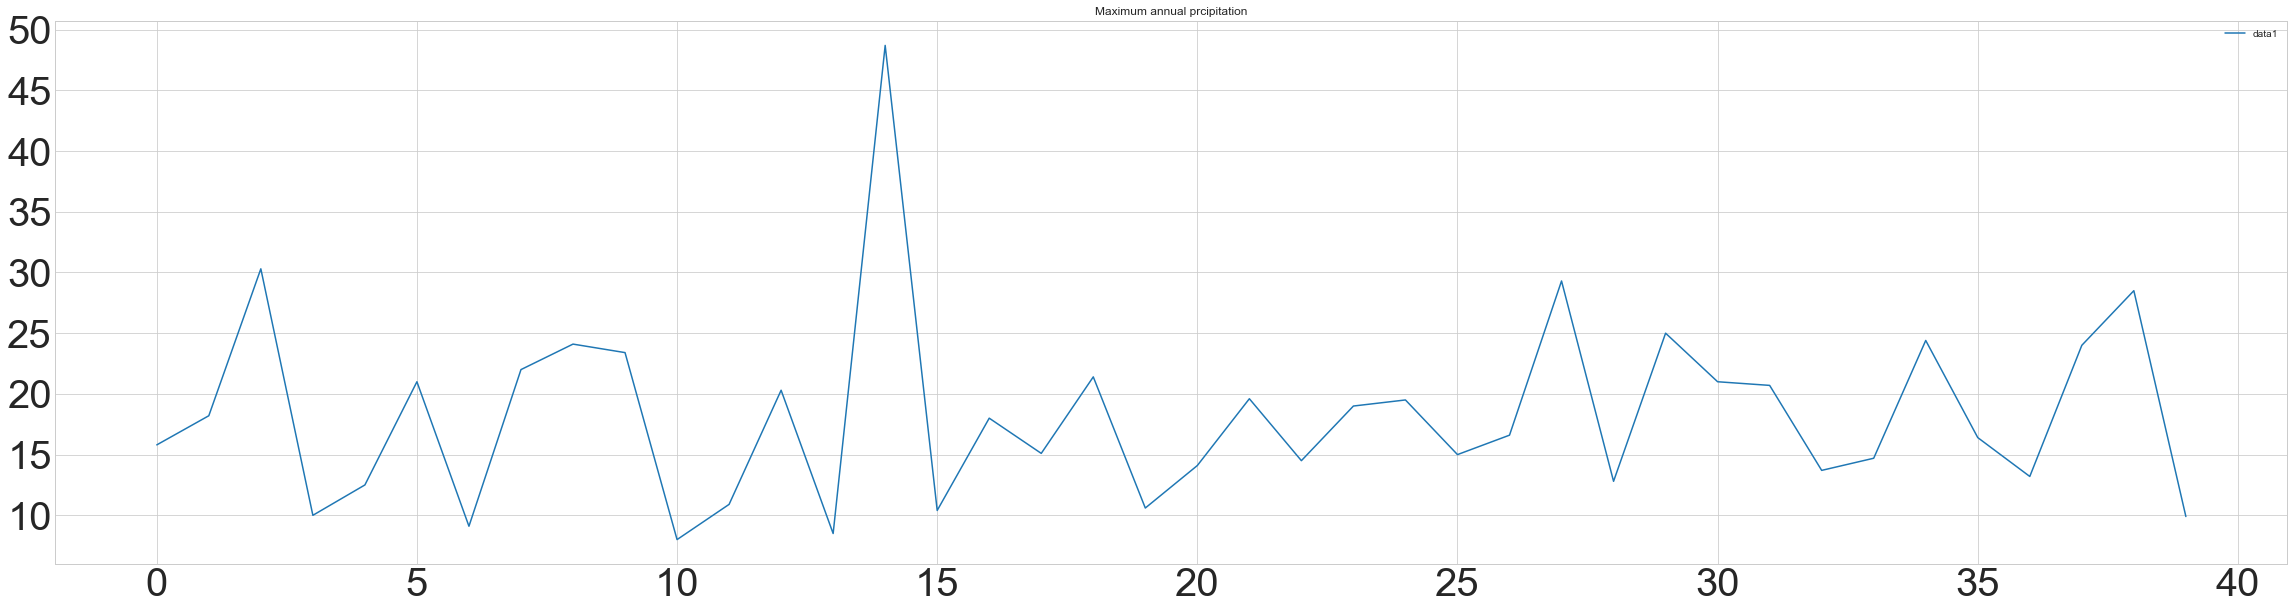

In [59]:
datin.plot(kind='line', figsize=[40,10], fontsize = 40, title = 'Maximum annual prcipitation')

<AxesSubplot:title={'center':'Maximum annual prcipitation'}, ylabel='Frequency'>

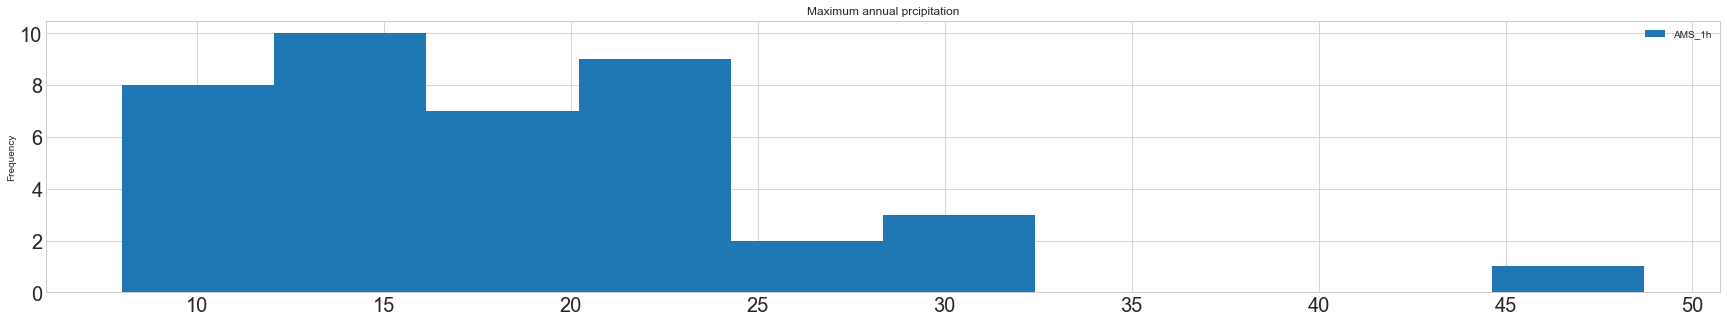

In [60]:
data1.plot(kind='hist',y ='AMS_1h', figsize=[30,5], fontsize = 20, title = 'Maximum annual prcipitation')

In [61]:
# use scipy.stats to get the 'best guess' values of parameters
shape1, loc1, scale1 =stats.genextreme.fit(datin.data1)
print(shape1, loc1, scale1)

-0.07499057642487139 14.728076996350378 5.386821894629199


In [62]:
# write the code for inference using the Bayesian 'machinery'

#define prior
def log_prior(par):
    par = par[1:3]
    if(all(i >= 0 for i in par)):
        return 0
    else:
        return -np.inf

#define likelihood function

def log_lik_gev(par,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(stats.genextreme(par[0],par[1],par[2]).pdf([data])))

#define posterior
def log_post(par, data):
    if (log_prior(par)==-np.inf):
        lp = log_prior(par)
    else: 
        lp = log_lik_gev(par,data)
    return lp   

In [63]:
# check whether the functions work
a = log_prior((-0.1,-0.1,-0.1))
b = log_lik_gev((-0.1,0.1,0.1),datin.data1)
c = log_post((-0.1,-0.1,0.1), datin.data1)
a, b, c

(-inf, -1176.4506710272246, -inf)

In [64]:
#Define jumpt distribution or the transition model

transition_model = lambda x: x+np.random.normal(0,0.1,len(x))

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))

# Define the MCMC algorithm
    
def metropolis_hastings(likelihood_computer, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        
        if (acceptance_rule(x_lik,x_new_lik)):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)
            accepted.append(x)
                
    return np.array(accepted), np.array(rejected)

In [65]:
accepted, rejected = metropolis_hastings(likelihood_computer = log_post, transition_model = transition_model,param_init = (-0.008,1.5,1.5), iterations = 10000, data =datin.data1, acceptance_rule = acceptance)

<ipython-input-62-fe8f1c685df3>:16: RuntimeWarning:

divide by zero encountered in log



In [66]:
xi, mu, sig = accepted[:,0].mean(), accepted[5000:,1].mean(), accepted[5000:,2].mean()
xi, mu, sig # infered parameter 

(-0.13819641444451933, 14.60266066131854, 5.589754899531102)

In [67]:
spread = accepted[:,0].std(), accepted[5000:,1].std(), accepted[5000:,2].std()
spread

(0.17241511574168097, 0.8882259665453719, 0.6891420940367626)

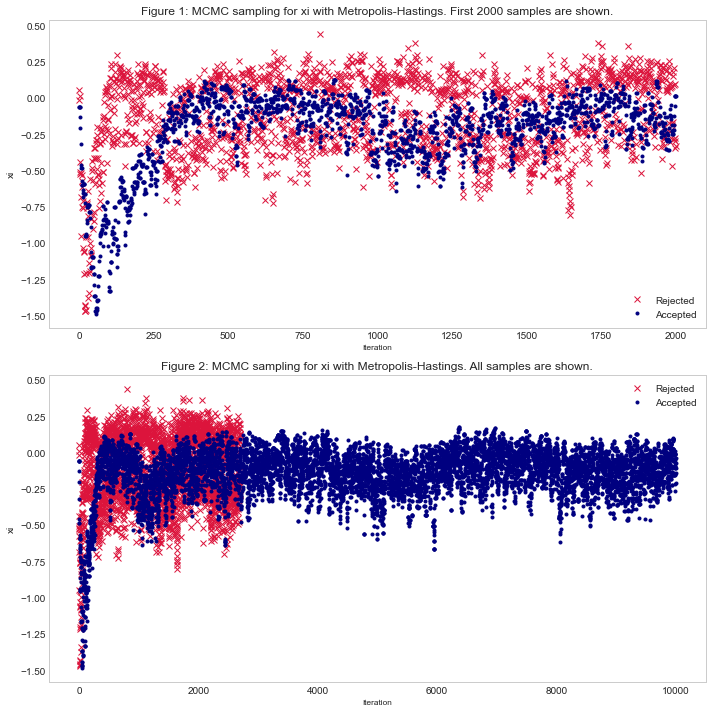

In [68]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:2000,0], 'rx', label='Rejected',alpha=1, color='crimson')
ax.plot( accepted[0:2000,0], 'b.', label='Accepted',alpha=1, color='navy')
ax.set_xlabel("Iteration", fontsize="small")
ax.set_ylabel("xi")
ax.set_title("Figure 1: MCMC sampling for xi with Metropolis-Hastings. First 2000 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,0], 'rx', label='Rejected',alpha=1, color='crimson')
ax2.plot( accepted[to_show:,0], 'b.', label='Accepted',alpha=1, color='navy')
ax2.set_xlabel("Iteration", fontsize="small")
ax2.set_ylabel("xi")
ax2.set_title("Figure 2: MCMC sampling for xi with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()

                                 

fig.tight_layout()
accepted.shape
plt.savefig('plot.png',dpi=170, bbox_inches='tight')

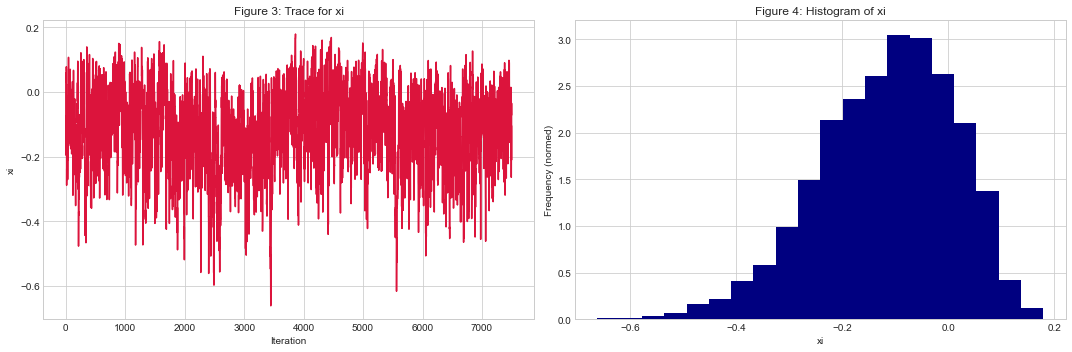

In [69]:
plt.style.use('seaborn-whitegrid')
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,0], alpha=1, color='crimson')
ax.set_title("Figure 3: Trace for xi")
ax.set_ylabel("xi")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,0], bins=20,density=True, alpha=1,  color='navy')
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("xi")
ax.set_title("Figure 4: Histogram of xi")
fig.tight_layout()


ax.grid("off")
plt.savefig('plot.jpg', bbox_inches='tight')

In [55]:
xi_mean = xi.mean()
mu_mean = mu.mean()
sig_mean = sig.mean()

xi_std = xi.std()
mu_std = mu.std()
sig_std = sig.std()